# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Шаги по выполнению проекта

Проведем исследовательский анализ набора фотографий. Сделаем выводы о том, как результаты исследования повлияют на обучение модели. 
Этапы анализа:
Посмотрим на размер выборки.
Построим график распределения возраста в выборке.
Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.
Подготовим данные к обучению.
Обучим нейронную сеть и рассчитаем её качество.


**Описание данных**

Данные взяты с сайта ChaLearn Looking at People. 

Они находятся в папке /datasets/faces/
В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

Извлечь данные из папки вам поможет новый метод ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...).

**Загрузим библиотеки**

In [2]:
from PIL import Image
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault

PATH = '/datasets/faces/'

## Исследовательский аналих данных

### Просмотрим общую информацию по датафрейму

In [3]:
data = pd.read_csv(PATH + 'labels.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


(7591, 2)

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

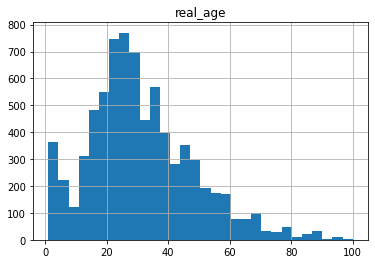

Количество явных дубликатов: 0
Количество пропусков: file_name    0
real_age     0
dtype: int64
Размерность: (7591, 2)


In [4]:
# Анализ датафрейма
display(data.info())
display(data.head())
display(data.shape)
display(data.describe())
display(data.describe().T)
display(data.hist(bins=30))
plt.show()
print(f"Количество явных дубликатов: {data.duplicated().sum()}")
print(f"Количество пропусков: {data.isna().sum()}")
print(f"Размерность: {data.shape}")


**Вывод:**
* Датафрейм состоит из 7591 записи и 2 столбцов, где, file_name - столбец с названиями файлов, а real_age - возраст - целевой признак
* Явные дубликаты отсутствуют
* Пропуски отсутствуют
* Типы данных соответствуют данным
* Распределение данных похоже на нормальных, диапазон значений от 0 до 100 лет. Пик количества записей в возрасте от 20 до 30, также наблюдается всплеск в значениях 0 - 5. Также можно заметить, что при увеличении возраста, количество фотографий уменьшается, скорее всего связано с особенностями сбором самих фотографий.

### Анализ изображений

Выведем на экран 15 изображений для их последующего анализа


Файл       : 000000.jpg
Возраст    : 4
Размерность: (114, 114, 3)


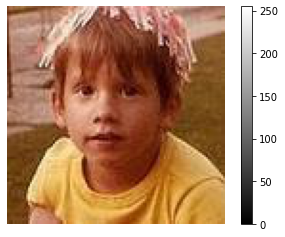


Файл       : 000001.jpg
Возраст    : 18
Размерность: (784, 784, 3)


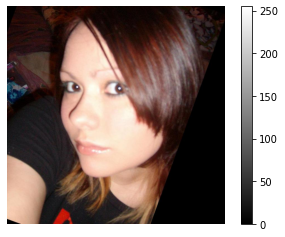


Файл       : 000002.jpg
Возраст    : 80
Размерность: (133, 133, 3)


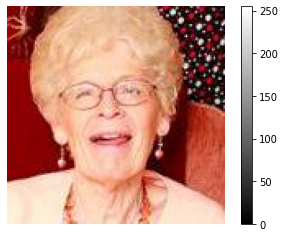


Файл       : 000003.jpg
Возраст    : 50
Размерность: (370, 370, 3)


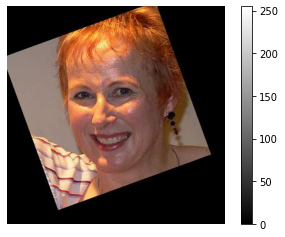


Файл       : 000004.jpg
Возраст    : 17
Размерность: (212, 212, 3)


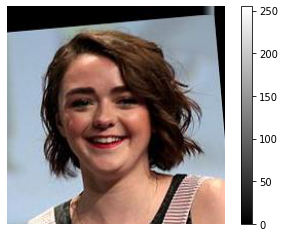


Файл       : 000005.jpg
Возраст    : 27
Размерность: (636, 637, 3)


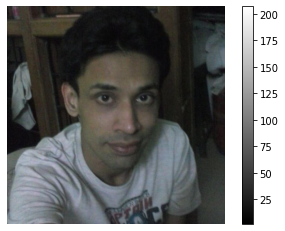


Файл       : 000006.jpg
Возраст    : 24
Размерность: (412, 412, 3)


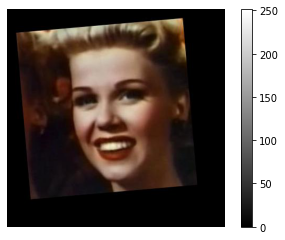


Файл       : 000007.jpg
Возраст    : 43
Размерность: (311, 311, 3)


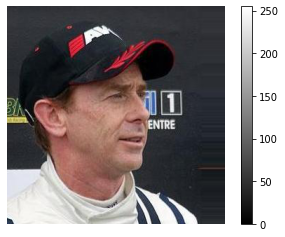


Файл       : 000008.jpg
Возраст    : 26
Размерность: (898, 897, 3)


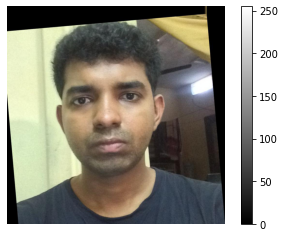


Файл       : 000009.jpg
Возраст    : 39
Размерность: (724, 724, 3)


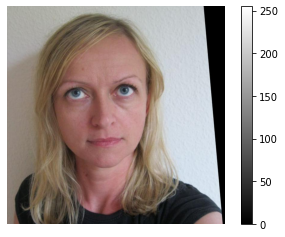


Файл       : 000010.jpg
Возраст    : 17
Размерность: (636, 636, 3)


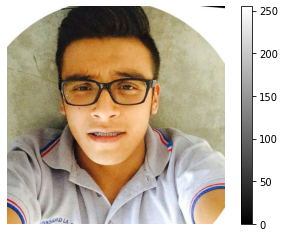


Файл       : 000011.jpg
Возраст    : 51
Размерность: (803, 803, 3)


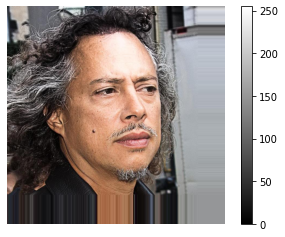


Файл       : 000012.jpg
Возраст    : 2
Размерность: (155, 155, 3)


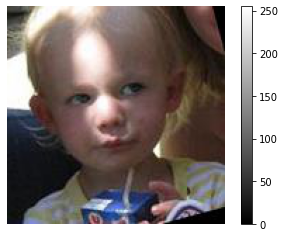


Файл       : 000013.jpg
Возраст    : 1
Размерность: (321, 321, 3)


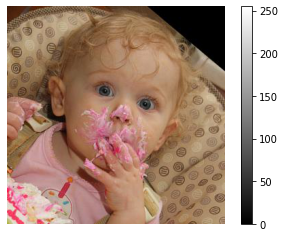


Файл       : 000014.jpg
Возраст    : 6
Размерность: (203, 204, 3)


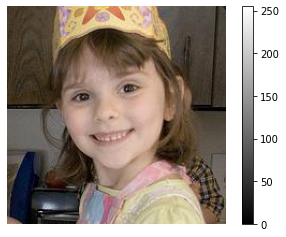

In [5]:
for i in range(0, 15):
    
    print()
    print('Файл       :', data.loc[i, 'file_name'])
    print('Возраст    :', data.loc[i, 'real_age'])
    
    if i < 10:
        file_dir = PATH + 'final_files/00000'+ str(i) + '.jpg'
    elif i < 100:
        file_dir = PATH + 'final_files/0000'+ str(i) + '.jpg'
    image = Image.open(file_dir)
    array = np.array(image)
    
    print('Размерность:', array.shape) 

    plt.imshow(array, cmap='gray') 
    plt.colorbar()
    plt.axis('off')
    plt.show()

**Вывод:**
* Все изображения содержаться в файлах формата jpg, имеют три цветовых канала RGB, квадратную форму и разные размеры. Для предсказания потребуется сверточная нейросеть типа ResNet
* Фотографии уже обработаны так, что лица расположены вертикально и занимают основную часть кадра. Это позволяет обойтись без дополнительной обработки изображений — достаточно применять аугментацию данных во время подготовки тренировочного набора
* Фотографии в среднем все квадратные, при этом некоторые из них, из-за поворота оставили черный фон,возраст в среднем примерно соответсвует возрасту человека на фотографии

## Обучение модели

Целевая метрика обучения модели, – 'mean_absolute_error', – должна быть меньше 8.

В качестве функции потерь использована 'mean_squared_error'.

Решаемая в проекте задача является задачей регрессии.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

from PIL import Image

from tensorflow import keras

from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import metrics

import numpy as np


PATH = '/datasets/faces/'
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, 
        rescale=1/255, 
        horizontal_flip = True
)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw', 
        subset='training',
        seed=12345)

    return train_gen_flow
 создаем функцию для зарузки валидационной выборки
 
def load_test(path):
    validation_datagen = ImageDataGenerator(validation_split=0.25, 
        rescale=1/255)

    val_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=12345)

    return val_gen_flow
 создаем функцию, формирующую модель обучения нейросети
 
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, 
                  loss='mse',
                  metrics=['mae'])

    return model
 создадим функцию обучения модели
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):

    features_train = train_data
    features_test = test_data
    model.fit(features_train, 
              validation_data=(features_test),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

Train for 178 steps, validate for 60 steps

Epoch 1/15 

178/178 - 63s - loss: 230.0691 - mae: 10.8207 - val_loss: 802.0764 - val_mae: 23.4026 

Epoch 2/15 

178/178 - 52s - loss: 77.4476 - mae: 6.6245 - val_loss: 599.1925 - val_mae: 19.4025 

Epoch 3/15 

178/178 - 51s - loss: 48.9842 - mae: 5.3275 - val_loss: 274.5870 - val_mae: 12.0647 

Epoch 4/15 

178/178 - 43s - loss: 34.3861 - mae: 4.4730 - val_loss: 124.9543 - val_mae: 8.6722 

Epoch 5/15 

178/178 - 43s - loss: 28.4306 - mae: 4.0613 - val_loss: 83.2427 - val_mae: 6.7982 

Epoch 6/15 

178/178 - 44s - loss: 23.8490 - mae: 3.7003 - val_loss: 74.4858 - val_mae: 6.4299 

Epoch 7/15 

178/178 - 43s - loss: 18.7649 - mae: 3.3518 - val_loss: 83.8658 - val_mae: 6.8013 

Epoch 8/15 

178/178 - 44s - loss: 15.5621 - mae: 3.0651 - val_loss: 61.5273 - val_mae: 5.8360 

Epoch 9/15 

178/178 - 44s - loss: 12.6931 - mae: 2.7141 - val_loss: 75.8698 - val_mae: 6.3625 

Epoch 10/15 

178/178 - 43s - loss: 10.4273 - mae: 2.4664 - val_loss: 62.8489 - val_mae: 5.9345 

Epoch 11/15 

178/178 - 44s - loss: 8.7932 - mae: 2.2397 - val_loss: 63.4748 - val_mae: 5.9486 

Epoch 12/15 

178/178 - 44s - loss: 8.1892 - mae: 2.1756 - val_loss: 61.0355 - val_mae: 5.8581 

Epoch 13/15 

178/178 - 44s - loss: 7.6132 - mae: 2.0801 - val_loss: 62.7754 - val_mae: 5.8606 

Epoch 14/15 

178/178 - 44s - loss: 7.3760 - mae: 2.0405 - val_loss: 80.0448 - val_mae: 6.7212 

Epoch 15/15 

178/178 - 49s - loss: 6.5721 - mae: 1.9397 - val_loss: 65.1407 - val_mae: 6.1164 

60/60 - 13s - loss: 65.1407 - mae: 6.1164

## Анализ обученной модели

Обучение нейросетевой модели на основе ResNet50 с дообучением на датасете изображений лиц успешно завершено. Валидационная метрика MAE (Mean Absolute Error) составила 6.1164 лет, что ниже целевого значения 8. Это означает, что модель в среднем ошибается в предсказании возраста человека менее чем на 7 лет.

Анализ качества модели

* Точность предсказаний
     * Текущий результат приемлем для задач, где допустима погрешность в ±7 лет (например, рекомендательные системы).
     * Однако для строгих сценариев (контроль продажи алкоголя, верификация возраста) точность недостаточна.
* Ограничения датасета
    * Неравномерное распределение возрастов:
    * Преобладание людей среднего возраста (30–50 лет).
    * Дефицит данных по детям, подросткам и пожилым людям.

Модель достигла приемлемого результата, но требует доработки датасета и гиперпараметров для повышения точности. В текущем виде применима только для задач с мягкими требованиями к погрешности.